In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

In [2]:
pqcd_region_dict = pqcd.get_pqcd_region()

Text(0.5, 0, '$\\mu$ [GeV]')

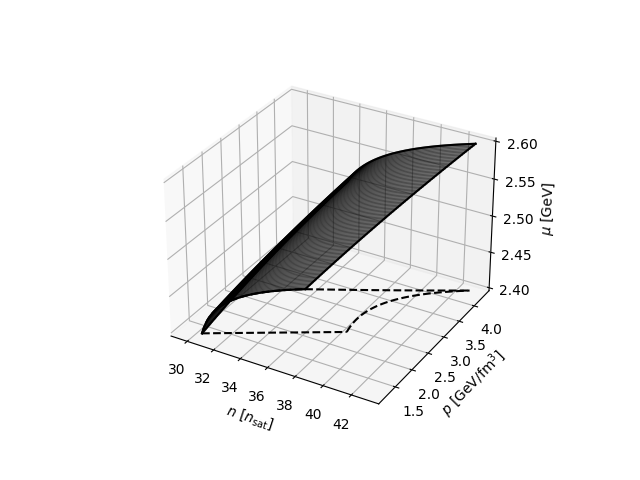

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
ax.set_zlabel(r'$\mu$ [GeV]')

In [4]:
# Overplot some EOSs

set = 6
good_EOSs = []

N_samp = 2000

for variety in ['had', 'hyp', 'qrk']:
    for n in range(N_samp):

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            good_EOSs.append((variety, n))

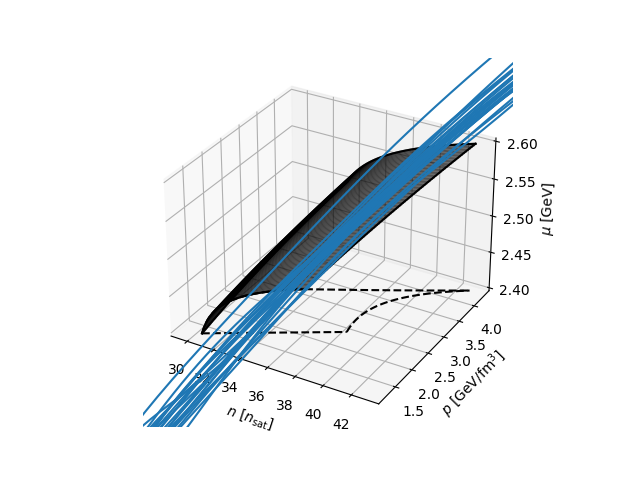

In [5]:
# Full EOS

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for variety, n in good_EOSs:

    eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density

    ax.plot(
        number_density/nsat, 
        pressure,
        chemical_potential,
        c='C0'
    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

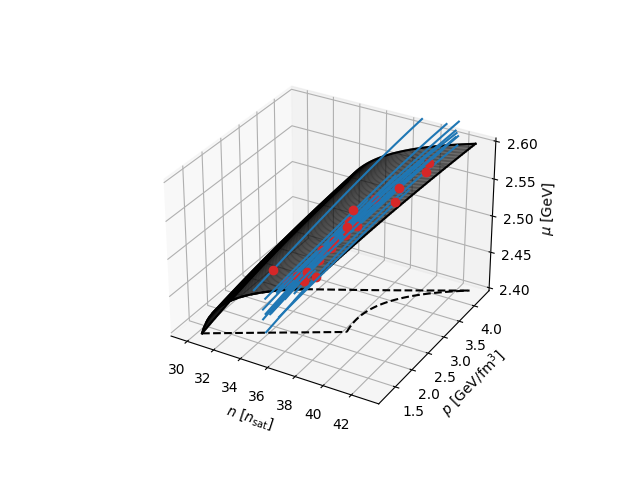

In [6]:
# Windowed EOS

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for variety, n in good_EOSs:

    eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density

    inside_region_n = []
    inside_region_p = []
    inside_region_mu = []

    for n, p, mu in zip(number_density, pressure, chemical_potential):
        if pqcd_region_dict['p_boundary_min'] < p < pqcd_region_dict['p_boundary_max']:
            min_n = pqcd_region_dict['left_n_boundary'][np.argmin(np.abs(pqcd_region_dict['left_p_boundary']-p))]
            max_n = pqcd_region_dict['right_n_boundary'][np.argmin(np.abs(pqcd_region_dict['right_p_boundary']-p))]
            if min_n < n < max_n:
                inside_region_n.append(n)
                inside_region_p.append(p)
                inside_region_mu.append(mu)

    # Find the location where the EOS crosses the surface

    # Variable to keep track of the smallest distance between our EOS and 
    # the PQCD boundary
    delta = 10

    for n, p, mu in zip(inside_region_n, inside_region_p, inside_region_mu):
        for dense_mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
            distances = (dense_n_array-n)**2 + (dense_p_array-p)**2 + (dense_mu-mu)**2
            near_point_index = np.argmin(distances)
            proposed_delta = distances[near_point_index]
            if proposed_delta < delta:
                delta = proposed_delta
                near_point = (dense_n_array[near_point_index], dense_p_array[near_point_index], dense_mu)

    ax.plot(
        np.array(inside_region_n)/nsat, 
        inside_region_p,
        inside_region_mu,
        c='C0'
    )

    ax.plot(
        near_point[0]/nsat, near_point[1], near_point[2],
        c='C3',
        marker='o'
    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

Repeat for a higher upper bound on mu

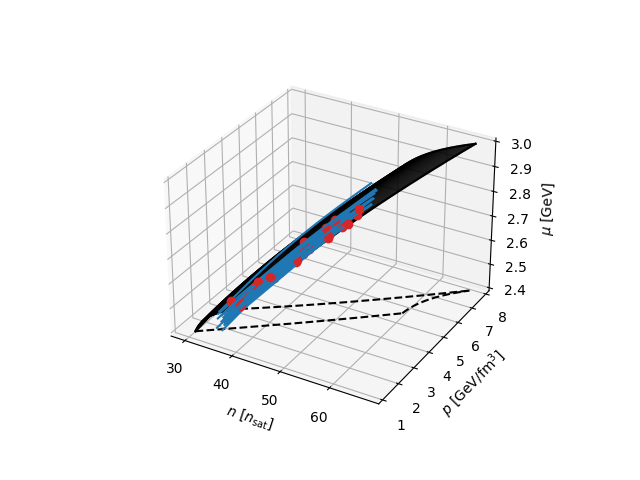

In [11]:
pqcd_region_dict = pqcd.get_pqcd_region(mu_high=3, res=200)

set = 6
good_EOSs = []

N_samp = 2000

for variety in ['had', 'hyp', 'qrk']:
    for n in range(N_samp):

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            good_EOSs.append((variety, n))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for variety, n in good_EOSs:

    eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density

    inside_region_n = []
    inside_region_p = []
    inside_region_mu = []

    for n, p, mu in zip(number_density, pressure, chemical_potential):
        if pqcd_region_dict['p_boundary_min'] < p < pqcd_region_dict['p_boundary_max']:
            min_n = pqcd_region_dict['left_n_boundary'][np.argmin(np.abs(pqcd_region_dict['left_p_boundary']-p))]
            max_n = pqcd_region_dict['right_n_boundary'][np.argmin(np.abs(pqcd_region_dict['right_p_boundary']-p))]
            if min_n < n < max_n:
                inside_region_n.append(n)
                inside_region_p.append(p)
                inside_region_mu.append(mu)

    # Find the location where the EOS crosses the surface

    # Variable to keep track of the smallest distance between our EOS and 
    # the PQCD boundary
    delta = 10

    for n, p, mu in zip(inside_region_n, inside_region_p, inside_region_mu):
        for dense_mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
            distances = (dense_n_array-n)**2 + (dense_p_array-p)**2 + (dense_mu-mu)**2
            near_point_index = np.argmin(distances)
            proposed_delta = distances[near_point_index]
            if proposed_delta < delta:
                delta = proposed_delta
                near_point = (dense_n_array[near_point_index], dense_p_array[near_point_index], dense_mu)

    ax.plot(
        np.array(inside_region_n)/nsat, 
        inside_region_p,
        inside_region_mu,
        c='C0'
    )

    ax.plot(
        near_point[0]/nsat, near_point[1], near_point[2],
        c='C3',
        marker='o'
    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

In [12]:
len(good_EOSs)

38

In [45]:
mu_highs = np.linspace(2.4, 3.2, 17)
good_EOSs = []

set = 6
N_samp = 2000

for mu_high in mu_highs:
    count = 0
    if mu_high != 2.4:
        pqcd_region_dict = pqcd.get_pqcd_region(mu_high=mu_high, res=int(25*20*(mu_high-2.4)))
        for variety in ['had', 'hyp', 'qrk']:
            for n in range(N_samp):
                eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
                if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                    count += 1
    good_EOSs.append(count)

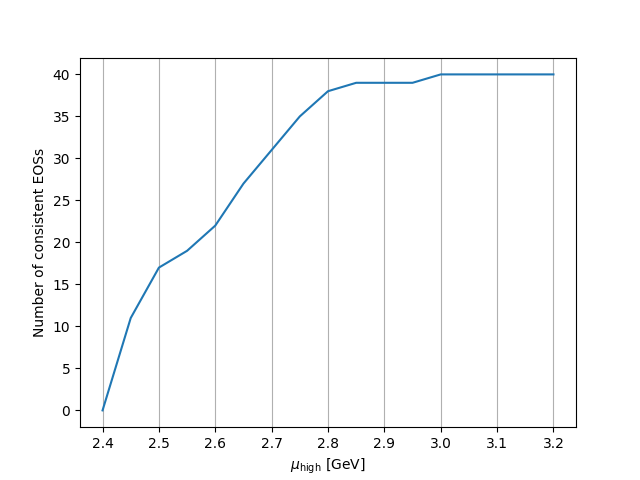

In [46]:
fig, ax = plt.subplots()

ax.plot(mu_highs, good_EOSs)

ax.grid(axis='x')

ax.set_xlabel(r'$\mu_{\rm high}$ [GeV]')
_ = ax.set_ylabel('Number of consistent EOSs')